In [325]:
# Importation 
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import os
import openpyxl
from tsfresh import extract_features, select_features
directory = os.getcwd()

# Author: Romain Tavenard
# License: BSD 3 clause

import numpy
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt

from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import LearningShapelets, \
    grabocka_params_to_shapelet_size_dict
from tslearn.utils import ts_size
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

import math
import random 
import numpy
from matplotlib import pyplot
from matplotlib import cm
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
import torch
from torch import nn, optim


# Pré-processing

               parcelle       date  ndvi_moy  ndvi_et annee
date                                                       
2022-04-05     aubiet11 2022-04-05      1616      969  2022
2022-04-10     aubiet11 2022-04-10      1765      900  2022
2022-04-25     aubiet11 2022-04-25      2428     1003  2022
2022-04-30     aubiet11 2022-04-30      1998      551  2022
2022-05-10     aubiet11 2022-05-10      1692     1001  2022
...                 ...        ...       ...      ...   ...
2020-08-06  209gers2020 2020-08-06      5720     1453  2020
2020-08-08  209gers2020 2020-08-08      5398     1398  2020
2020-08-16  209gers2020 2020-08-16      5589     1162  2020
2020-08-21  209gers2020 2020-08-21      5652     1356  2020
2020-08-26  209gers2020 2020-08-26      5812     1179  2020

[1440 rows x 5 columns]


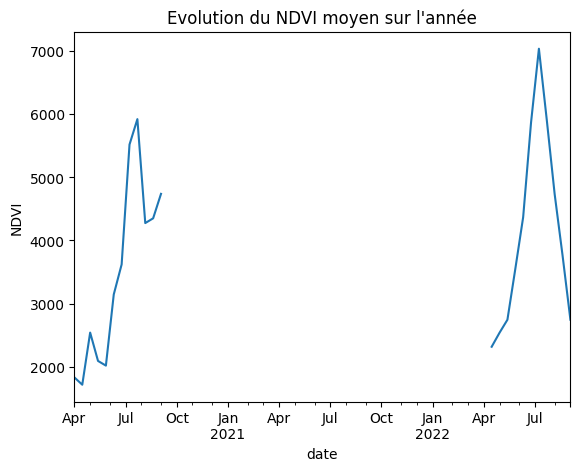

In [326]:
# Importation données NDVI
donnees = pd.read_csv(f"{directory}/donnees/resultats_new.csv", sep = ";", parse_dates = ["date"], dayfirst = True)
donnees = donnees.loc[:,["parcelle","date","NDVI_moy","NDVI_et"]]

# Typage des colonnes
donnees['parcelle'] = donnees['parcelle'].astype('string')
donnees["parcelle"] = donnees["parcelle"].map(lambda x:x.replace('_','').lower())
donnees.columns = donnees.columns.str.replace('NDVI_moy', 'ndvi_moy')
donnees.columns = donnees.columns.str.replace('NDVI_et', 'ndvi_et')
donnees = donnees.set_index('date', drop = False)

donnees["annee"] = donnees["date"].dt.year # on utilise cette colonne annee pour les jointures pr récup le peuplement et le précédent
donnees["annee"] = donnees["annee"].astype('string')

# Graphe évolution NDVI moyenné par mois
# sns.lineplot(x="date", y="ndvi", data=donnees, hue="parcelle", legend = False)
donnees["ndvi_moy"].resample("2W").mean().plot(title = "Evolution du NDVI moyen sur l'année", ylabel = "NDVI")

print(donnees)


In [327]:
peuplement_1 = pd.read_excel(f"{directory}/donnees/peuplement/donnees2022_BA-2.xlsx", engine='openpyxl', parse_dates = ["date"])
peuplement_1 = peuplement_1.loc[:,["parcelle","date","peuplement"]]
peuplement_1["annee"] = peuplement_1['date'].dt.year
peuplement_1 = peuplement_1.drop(["date"], axis=1)

peuplement_2 = pd.read_excel(f"{directory}/donnees/peuplement/Placette_TRN22_beauce.xlsx", engine='openpyxl', parse_dates = ["date_obs"])
peuplement_2 = peuplement_2.loc[:,["numero_parcelle","date_obs","peuplement"]]
peuplement_2.columns = peuplement_2.columns.str.replace('numero_parcelle', 'parcelle')
peuplement_2.columns = peuplement_2.columns.str.replace('date_obs','date')
peuplement_2["annee"] = peuplement_2['date'].dt.year
peuplement_2 = peuplement_2.drop(["date"], axis=1)
peuplement_2 = peuplement_2[peuplement_2["parcelle"] != "80_22"] # la dernière ligne a un NA dans col peuplement

peuplement_3 = pd.read_csv(f"{directory}/donnees/peuplement/crop_pro.csv", decimal = ".", sep = ";", encoding = "ISO-8859-1")
peuplement_3 = peuplement_3.loc[:,["ID","annee","viables"]]
peuplement_3.columns = peuplement_3.columns.str.replace('ID', 'parcelle')
peuplement_3.columns = peuplement_3.columns.str.replace('viables', 'peuplement')

peuplement_4 = pd.read_csv(f"{directory}/donnees/peuplement/comptages_yonne_2022.csv", decimal = ",", sep = ";", encoding = "ISO-8859-1", parse_dates = ["date"])
peuplement_4 = peuplement_4.loc[:,["id_parcelle","agri_parcelle","date","peuplement"]]
peuplement_4["parcelle"] = peuplement_4["id_parcelle"].astype(str) + peuplement_4["agri_parcelle"].astype(str)
peuplement_4["parcelle"] = peuplement_4["parcelle"].map(lambda x:x.replace('_','').lower())
peuplement_4["annee"] = pd.Series([2022 for i in range(peuplement_4.shape[0])])
peuplement_4 = peuplement_4.drop(["id_parcelle","agri_parcelle","date"], axis=1)


peuplement = pd.concat([peuplement_1, peuplement_2, peuplement_3, peuplement_4], axis=0)
peuplement["parcelle"] = peuplement["parcelle"].map(lambda x:x.replace('_','').lower())
peuplement['parcelle'] = peuplement['parcelle'].astype('string')
peuplement["annee"] = peuplement["annee"].astype('int')
peuplement = peuplement.groupby(["parcelle","annee"]).agg({"peuplement":["mean"]})
peuplement.columns = peuplement.columns.droplevel()
peuplement.columns = ["peuplement"]
peuplement = peuplement.reset_index()
print(peuplement)



        parcelle  annee  peuplement
0           0222   2022     70400.0
1           0522   2022     64800.0
2           0622   2022     52800.0
3          10022   2022     65200.0
4    100gers2019   2019     58000.0
..           ...    ...         ...
296  tirosieres4   2022     41200.0
297   tivillers5   2022     79600.0
298   tivillers6   2022     72000.0
299   tivillers7   2022     94000.0
300   tivillers8   2022     82000.0

[301 rows x 3 columns]


/var/folders/_5/0hwbw52j18d6422q8hkswk2m0000gn/T/ipykernel_19817/1817326757.py:19: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  peuplement_4 = pd.read_csv(f"{directory}/donnees/peuplement/comptages_yonne_2022.csv", decimal = ",", sep = ";", encoding = "ISO-8859-1", parse_dates = ["date"])


In [328]:
# Intégration aux données NDVI
peuplement['annee'] = peuplement['annee'].astype('string')

donnees = donnees.merge(peuplement,on=['parcelle','annee'],how='left')

donnees['parcelle'] = donnees['parcelle'].astype('string')

In [329]:
print(donnees)

         parcelle       date  ndvi_moy  ndvi_et annee    peuplement
0        aubiet11 2022-04-05      1616      969  2022  36416.666667
1        aubiet11 2022-04-10      1765      900  2022  36416.666667
2        aubiet11 2022-04-25      2428     1003  2022  36416.666667
3        aubiet11 2022-04-30      1998      551  2022  36416.666667
4        aubiet11 2022-05-10      1692     1001  2022  36416.666667
...           ...        ...       ...      ...   ...           ...
1435  209gers2020 2020-08-06      5720     1453  2020  37000.000000
1436  209gers2020 2020-08-08      5398     1398  2020  37000.000000
1437  209gers2020 2020-08-16      5589     1162  2020  37000.000000
1438  209gers2020 2020-08-21      5652     1356  2020  37000.000000
1439  209gers2020 2020-08-26      5812     1179  2020  37000.000000

[1440 rows x 6 columns]


In [330]:
donnees = donnees.sort_values(["parcelle","date"])
donnees = donnees.dropna(axis = 0, subset=['peuplement'])

df = donnees.loc[:,["parcelle","date","ndvi_moy"]]
y = donnees.loc[:,["parcelle","peuplement","annee"]].drop_duplicates().peuplement

y = y.reset_index(drop = True)
df = df.reset_index(drop = True)

In [331]:
print(y)

0     70400.000000
1     64800.000000
2     52800.000000
3     28800.000000
4     58666.666667
          ...     
87    41200.000000
88    79600.000000
89    72000.000000
90    94000.000000
91    82000.000000
Name: peuplement, Length: 92, dtype: float64


In [332]:
date=[]
for i in donnees['date'] :
    a = i.date()
    date.append(a)

In [333]:
#transformation des jours en jour julien
date_jour_julien = []
for i in date :
    if i.month <=5 :
        date_jour_julien.append((i.month-1)*30+i.day) 
    elif i.month <=7:
        date_jour_julien.append((i.month-1)*30+i.day+1)
    elif i.month ==8 :
        date_jour_julien.append((i.month-1)*30+i.day+2)

In [334]:
print(donnees)

       parcelle       date  ndvi_moy  ndvi_et annee  peuplement
341        0222 2022-05-10      3255      765  2022     70400.0
342        0222 2022-06-14      7444      427  2022     70400.0
343        0222 2022-06-19      6815      571  2022     70400.0
344        0222 2022-07-14      5632      612  2022     70400.0
345        0222 2022-07-24      4573      847  2022     70400.0
..          ...        ...       ...      ...   ...         ...
336  tivillers8 2022-08-17      2002      262  2022     82000.0
337  tivillers8 2022-08-20      2106      304  2022     82000.0
338  tivillers8 2022-08-22      1807      273  2022     82000.0
339  tivillers8 2022-08-25      1835      224  2022     82000.0
340  tivillers8 2022-08-30      2051       99  2022     82000.0

[1381 rows x 6 columns]


In [335]:
record =[]
for i in range (len(date)):
    a= [date[i],date_jour_julien[i]]
    record.append(a)

In [336]:
df_date = pd.DataFrame (record,columns=["date","date_jour_julien"]) 
print(df_date)

            date  date_jour_julien
0     2022-05-10               130
1     2022-06-14               165
2     2022-06-19               170
3     2022-07-14               195
4     2022-07-24               205
...          ...               ...
1376  2022-08-17               229
1377  2022-08-20               232
1378  2022-08-22               234
1379  2022-08-25               237
1380  2022-08-30               242

[1381 rows x 2 columns]


In [337]:
new_df= pd.concat([df,df_date],axis=1)

In [338]:
print(new_df)


        parcelle       date  ndvi_moy        date  date_jour_julien
0           0222 2022-05-10      3255  2022-05-10               130
1           0222 2022-06-14      7444  2022-06-14               165
2           0222 2022-06-19      6815  2022-06-19               170
3           0222 2022-07-14      5632  2022-07-14               195
4           0222 2022-07-24      4573  2022-07-24               205
...          ...        ...       ...         ...               ...
1376  tivillers8 2022-08-17      2002  2022-08-17               229
1377  tivillers8 2022-08-20      2106  2022-08-20               232
1378  tivillers8 2022-08-22      1807  2022-08-22               234
1379  tivillers8 2022-08-25      1835  2022-08-25               237
1380  tivillers8 2022-08-30      2051  2022-08-30               242

[1381 rows x 5 columns]


In [339]:
newdf = new_df.drop(['date'], axis=1)

In [340]:
# Stockage des données ndvi et leur index en jour de l'année associé dans une liste de liste 
parcelle_nb = df["parcelle"].drop_duplicates().values.tolist()
print(parcelle_nb)
groups = newdf.groupby(['parcelle'])
doy_ndvi = []
for name in parcelle_nb : 
    doy_ndvi.append([groups.get_group(name)['date_jour_julien'].values.tolist(),groups.get_group(name)['ndvi_moy'].values.tolist()])
print(doy_ndvi[:10])

['0222', '0522', '0622', '10horton', '11faucheux', '12jourlin', '13jourlin', '14jourlin', '15horton', '16douaie', '1722', '177gers2020', '178gers2020', '17douaie', '181gers2020', '182gers2020', '183gers2020', '184gers2020', '185gers2020', '186gers2020', '187gers2020', '188gers2020', '189gers2020', '190gers2020', '191gers2020', '192gers2020', '193gers2020', '194gers2020', '195gers2020', '196gers2020', '197gers2020', '198gers2020', '199gers2020', '19horton', '1fonteneilles', '200gers2020', '203gers2020', '204gers2020', '205gers2020', '206gers2020', '207gers2020', '208gers2020', '209gers2020', '20saison', '2822', '2922', '2saison', '3822', '3bretagne', '4222', '4422', '4522', '4722', '4horton', '5222', '5322', '5422', '5bretagne', '6222', '6322', '6622', '6722', '6philbe', '7122', '7322', '7422', '7522', '7622', '7822', '7philbe', '8222', '8822', '8philbe', '9fonteneilles', 'aubiet11', 'aubiet22', 'coulonges2', 'fdgeda1', 'fdgeda2', 'fdgeda6', 'fdgeda7', 'fdgeda8', 'lamagistere3', 'tiagen

In [341]:
parcelle_nb = df["parcelle"].drop_duplicates().values.tolist()
print(parcelle_nb)
groups = newdf.groupby(['parcelle'])
new_ndvi = []
for name in parcelle_nb : 
    new_ndvi.append(groups.get_group(name)['ndvi_moy'].values.tolist())

['0222', '0522', '0622', '10horton', '11faucheux', '12jourlin', '13jourlin', '14jourlin', '15horton', '16douaie', '1722', '177gers2020', '178gers2020', '17douaie', '181gers2020', '182gers2020', '183gers2020', '184gers2020', '185gers2020', '186gers2020', '187gers2020', '188gers2020', '189gers2020', '190gers2020', '191gers2020', '192gers2020', '193gers2020', '194gers2020', '195gers2020', '196gers2020', '197gers2020', '198gers2020', '199gers2020', '19horton', '1fonteneilles', '200gers2020', '203gers2020', '204gers2020', '205gers2020', '206gers2020', '207gers2020', '208gers2020', '209gers2020', '20saison', '2822', '2922', '2saison', '3822', '3bretagne', '4222', '4422', '4522', '4722', '4horton', '5222', '5322', '5422', '5bretagne', '6222', '6322', '6622', '6722', '6philbe', '7122', '7322', '7422', '7522', '7622', '7822', '7philbe', '8222', '8822', '8philbe', '9fonteneilles', 'aubiet11', 'aubiet22', 'coulonges2', 'fdgeda1', 'fdgeda2', 'fdgeda6', 'fdgeda7', 'fdgeda8', 'lamagistere3', 'tiagen

In [342]:
print(type(y))

<class 'pandas.core.series.Series'>


In [343]:
new_y = np.array(y)
donnees_array = donnees.to_numpy()

In [344]:
new_y= new_y.astype(int)
new_y = new_y.reshape(len(new_y),)

In [345]:
print((new_y))

[70400 64800 52800 28800 58666 14666 32333 28000 12952 30400 56000 54400
 66000  1600 13000 55000 53333 59285 37000 33142 66571 49666 63333 54333
 51666 48666 39666 59333 24000 59000 58545 52000 55200 24333 43555 61090
 30000 69454 61000 41333 38769 27600 37000 53000 75600 68000 36400 71600
 23759 43600 67200 68000 57600 62496 64400 56000 56000 40400 58800 54800
 50400 52000 36444 41200 33200 56800 61600 62000 30000 32444 39200 48400
 40000 35555 36416 30000 60555 37666 49333 29090 38181 45454 43666 36952
 35166 30222 38000 41200 79600 72000 94000 82000]


## INTERPOLATION

### faire une liste des longueurs des TS

In [346]:
debut = [ doy_ndvi[k][0][0] for k in  range (len(doy_ndvi))]
fin = [ doy_ndvi[k][0][-1]  for k in  range (len(doy_ndvi))]
le = [len(doy_ndvi[k][0])for k in range(len(doy_ndvi))]
print(debut,fin,le)
print(min(debut),max(fin))
print(max(debut),min(fin))

[130, 130, 130, 107, 100, 100, 100, 100, 107, 100, 130, 145, 95, 100, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 100, 100, 95, 95, 95, 95, 95, 95, 95, 93, 100, 130, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 130, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 95, 95, 113, 100, 100, 100, 100, 100, 100, 100, 123, 94, 94, 94, 94, 94, 94, 94] [225, 225, 240, 240, 240, 240, 240, 240, 240, 240, 225, 235, 235, 240, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 220, 220, 220, 220, 240, 237, 220, 220, 220, 220, 220, 220, 238, 238, 240, 225, 225, 240, 225, 240, 240, 225, 225, 225, 240, 225, 240, 240, 240, 225, 225, 240, 225, 240, 225, 225, 225, 240, 240, 240, 240, 225, 225, 240, 237, 240, 240, 223, 240, 240, 240, 240, 240, 240, 240, 223, 242, 242, 242, 242, 242, 242, 242] [8, 9, 10, 14, 16, 16, 16, 16, 15, 16, 9, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 14, 14, 14, 14, 14, 14, 1

### Création d'une liste de date pour tous les jours

In [347]:
all_dates=[]
for i in range (min(debut),max(fin)):
    all_dates.append(i)
print(all_dates)

[93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241]


In [348]:
tous_les_jours = []
for i in range (len(doy_ndvi)):
    indice = []
    val = []
    indi2=0
    for j in range(doy_ndvi[i][0][0],doy_ndvi[i][0][-1]+1):
        if j in doy_ndvi[i][0]:
            indice.append(j)
            val.append(doy_ndvi[i][1][indi2])
            indi2+=1
        else : 
            indice.append(j)
            val.append(np.nan)
    tous_les_jours.append([indice,val])

In [349]:
tous_les_jours_df = pd.DataFrame([tous_les_jours[0]], columns= ('jour','ndvi'))

In [350]:
print(tous_les_jours_df['ndvi'].interpolate())

0    [3255, nan, nan, nan, nan, nan, nan, nan, nan,...
Name: ndvi, dtype: object


In [351]:
data1 = pd.DataFrame(columns=['jour','ndvi'])
print(data1)

Empty DataFrame
Columns: [jour, ndvi]
Index: []


In [352]:
#On repasse tout ça en dataframe que l'on stocke dans une liste pour pouvoir utiliser l'interpolation
datalist = []
for parc in tous_les_jours : 
    datalist.append(pd.DataFrame(parc[0], columns= ['jour']))
    datalist[-1]["ndvi"] = parc[1]

In [353]:
print(datalist[0:1][0][0:2])

   jour    ndvi
0   130  3255.0
1   131     NaN


In [354]:
# On remplace les donnees manquantes par interpolation linaires 
df_interpolate = [ k.interpolate() for k in datalist]
ndvi2 = [[k['jour'].values.tolist() , k['ndvi'].values.tolist()] for k in df_interpolate]
print(ndvi2[0])

[[130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225], [3255.0, 3374.6857142857143, 3494.3714285714286, 3614.057142857143, 3733.7428571428572, 3853.4285714285716, 3973.114285714286, 4092.8, 4212.4857142857145, 4332.171428571429, 4451.857142857143, 4571.542857142857, 4691.228571428572, 4810.914285714285, 4930.6, 5050.285714285714, 5169.971428571429, 5289.657142857142, 5409.342857142858, 5529.028571428571, 5648.714285714286, 5768.4, 5888.085714285715, 6007.771428571428, 6127.457142857143, 6247.142857142857, 6366.828571428571, 6486.5142857142855, 6606.2, 6725.885714285

In [355]:
list_all_day = []
for i in range (len(ndvi2)):
    indice = []
    val = []
    indi2=0
    for j in range(min(debut),max(fin)+1):
        if j in ndvi2[i][0]:
            indice.append(j)
            val.append(ndvi2[i][1][indi2])
            indi2+=1
        else : 
            indice.append(j)
            val.append(np.nan)
    list_all_day.append([indice,val])

In [356]:
print(list_all_day[0])

[[93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242], [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 3255.0, 3374.6857142857143, 3494.3714285714286, 3614.057142857143, 3

In [357]:
cut_all_day = []
for i in range (len(ndvi2)):
    indice = []
    val = []
    indi2=0
    for j in range(max(debut),min(fin)+1):
        if j in ndvi2[i][0]:
            indice.append(j)
            val.append(ndvi2[i][1][indi2])
            indi2+=1
        else : 
            indice.append(j)
            val.append(np.nan)
    cut_all_day.append([indice,val])

In [358]:
all_ndvi =[]
for parc in cut_all_day : 
    all_ndvi.append(np.array(parc[1]))

In [359]:
all_ndvi_array = np.array(all_ndvi)

In [360]:
print(np.shape(all_ndvi_array))

(92, 76)


In [361]:
print(new_y)

[70400 64800 52800 28800 58666 14666 32333 28000 12952 30400 56000 54400
 66000  1600 13000 55000 53333 59285 37000 33142 66571 49666 63333 54333
 51666 48666 39666 59333 24000 59000 58545 52000 55200 24333 43555 61090
 30000 69454 61000 41333 38769 27600 37000 53000 75600 68000 36400 71600
 23759 43600 67200 68000 57600 62496 64400 56000 56000 40400 58800 54800
 50400 52000 36444 41200 33200 56800 61600 62000 30000 32444 39200 48400
 40000 35555 36416 30000 60555 37666 49333 29090 38181 45454 43666 36952
 35166 30222 38000 41200 79600 72000 94000 82000]


In [362]:
# séparation des rendements en deux classes (bonne parcelle /mauvaise parcelle)
test_class_y =[]
for i in range(len(new_y)): 
    if new_y[i] > 40000 : 
        test_class_y.append(1)
    else : 
        test_class_y.append(0)
print(test_class_y)

[1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]


In [363]:
#transformation en array pour utiliser dans la méthode learning shapelet
new_class_y  = np.array(test_class_y)
print(new_class_y)

[1 1 1 0 1 0 0 0 0 0 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0
 1 1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 0 0
 0 0 1 0 1 0 0 1 1 0 0 0 0 1 1 1 1 1]


In [364]:
# on verifie que le seuil pour créer les deux classes permet d'avoir deux classes équilibrés en nombre d'effectif. 
class1 = 0
class0 = 0
for i in range(len(test_class_y)):
    if test_class_y[i] ==1 :
        class1 += 1
    else :
        class0 += 1

print (class0,class1)

35 57


# Création du modèle

In [365]:
# Set seed for determinism
numpy.random.seed(0)

# On sépare nos exemples en ensemble d'entrainement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(all_ndvi_array, new_class_y, test_size=0.33, random_state=0)

In [366]:
# Normalize each of the timeseries in the Trace dataset
# un besoin du package learning shapelet. A laisser
X_train = TimeSeriesScalerMinMax().fit_transform(X_train)
X_test = TimeSeriesScalerMinMax().fit_transform(X_test)

In [370]:
# Path to root of this project, contains lots of modules
import sys
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.getcwd())

In [371]:
from src.learning_shapelets import LearningShapelets

In [372]:
# fonction nécessaire à la methode des learnings shapelets

def normalize_standard(X, scaler=None):
    shape = X.shape
    data_flat = X.flatten()
    if scaler is None:
        scaler = StandardScaler()
        data_transformed = scaler.fit_transform(data_flat.reshape(numpy.product(shape), 1)).reshape(shape)
    else:
        data_transformed = scaler.transform(data_flat.reshape(numpy.product(shape), 1)).reshape(shape)
    return data_transformed, scaler

def normalize_data(X, scaler=None):
    if scaler is None:
        X, scaler = normalize_standard(X)
    else:
        X, scaler = normalize_standard(X, scaler)
    
    return X, scaler

In [373]:
# normalize training data
X_train, scaler = normalize_data(X_train)

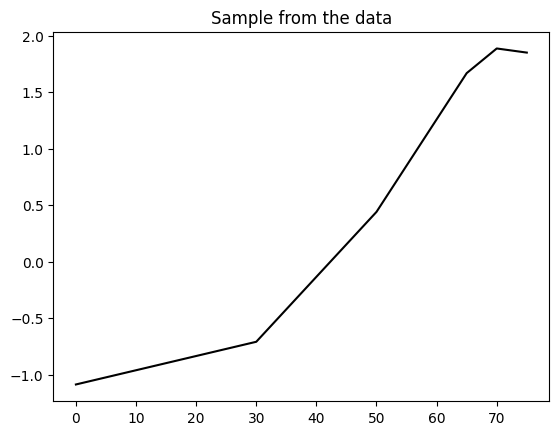

In [374]:
pyplot.title("Sample from the data")
pyplot.plot(X_train[0], color='black')

In [375]:
X_train = np.reshape(X_train,(len(X_train),1,len(X_train[0])))

In [377]:
def sample_ts_segments(X, shapelets_size, n_segments=10000):
    """
    Sample time series segments for k-Means.
    """
    n_ts, n_channels, len_ts = X.shape
    samples_i = random.choices(range(n_ts), k=n_segments)
    segments = numpy.empty((n_segments, n_channels, shapelets_size))
    for i, k in enumerate(samples_i):
        s = random.randint(0, len_ts - shapelets_size)
        segments[i] = X[k, :, s:s+shapelets_size]
    return segments

In [378]:
def get_weights_via_kmeans(X, shapelets_size, num_shapelets, n_segments=10000):
    """
    Get weights via k-Means for a block of shapelets.
    """
    segments = sample_ts_segments(X, shapelets_size, n_segments).transpose(0, 2, 1)
    k_means = TimeSeriesKMeans(n_clusters=num_shapelets, metric="euclidean", max_iter=50).fit(segments)
    clusters = k_means.cluster_centers_.transpose(0, 2, 1)
    return clusters

In [379]:
# normalize test data
X_test, scaler = normalize_data(X_test)
print(X_test.shape)
X_test = np.reshape(X_test,(len(X_test),1,len(X_test[0])))
print(X_test.shape)

(31, 76, 1)
(31, 1, 76)


Initialize parameters:

In [380]:
n_ts, n_channels, len_ts = X_train.shape
loss_func = nn.CrossEntropyLoss()
num_classes = len(set(y_train))
# apprendre 6 shapelets de longueur 20 mesures. Ce couple doit etre modifié et testé pour optimiser les résultats du modèle. (temps et accuracy)
shapelets_size_and_len = {20:6}
dist_measure = "euclidean"
lr = 1e-2
wd = 1e-3
epsilon = 1e-7

Initiatilisation du modèle : 

In [381]:
learning_shapelets = LearningShapelets(shapelets_size_and_len=shapelets_size_and_len,
                                       in_channels=n_channels,
                                       num_classes=num_classes,
                                       loss_func=loss_func,
                                       to_cuda=False,
                                       verbose=1,
                                       dist_measure=dist_measure)

Initialize shapelets via K-Means:

In [382]:
for i, (shapelets_size, num_shapelets) in enumerate(shapelets_size_and_len.items()):
    weights_block = get_weights_via_kmeans(X_train, shapelets_size, num_shapelets)
    learning_shapelets.set_shapelet_weights_of_block(i, weights_block)

Initialize optimizer:

In [383]:
optimizer = optim.Adam(learning_shapelets.model.parameters(), lr=lr, weight_decay=wd, eps=epsilon)
learning_shapelets.set_optimizer(optimizer)

### Train Model

Train the model:

In [384]:
print (len(X_train))

61


In [385]:
losses = learning_shapelets.fit(X_train, y_train, epochs=3000, batch_size=len(X_train), shuffle=False, drop_last=False)

Loss: 0.28923407196998596: 100%|██████████| 3000/3000 [00:31<00:00, 94.11it/s] 


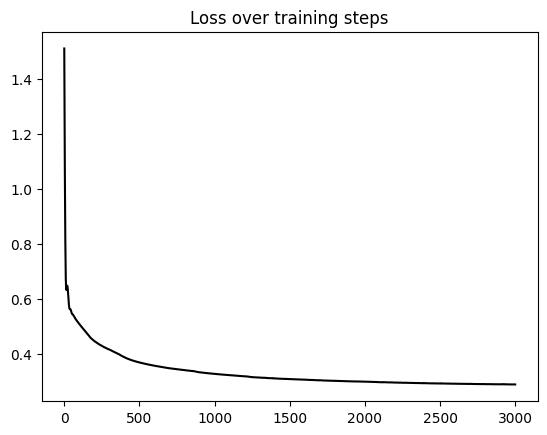

In [386]:
pyplot.plot(losses, color='black')
pyplot.title("Loss over training steps")
pyplot.show()

### Evaluate Model

In [387]:
def eval_accuracy(model, X, Y):
    predictions = model.predict(X)
    if len(predictions.shape) == 2:
        predictions = predictions.argmax(axis=1)
        print(predictions)
    print(f"Accuracy: {(predictions == Y).sum() / Y.size}")

In [389]:
#création de d'étiquettes aléatoires pour voir si le modèle est meilleur que le hasard 
y_aleatoire =[]
for i in range (len(y_test)):
    y_aleatoire.append(random.randint(0,1))

In [390]:
print((y_test))
print(y_aleatoire)

[2, 1, 0, 2, 2, 0, 1, 0, 2, 0, 0, 1, 0, 1, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 0, 0, 0, 2, 0, 2]


In [391]:
accuracy_score(y_test,y_aleatoire)

0.1935483870967742

In [392]:
eval_accuracy(learning_shapelets, X_test, y_test)


[1 1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1]
Accuracy: 0.5806451612903226


In [393]:
def torch_dist_ts_shapelet(ts, shapelet, cuda=True):
    """
    Calculate euclidean distance of shapelet to a time series via PyTorch and returns the distance along with the position in the time series.
    """
    if not isinstance(ts, torch.Tensor):
        ts = torch.tensor(ts, dtype=torch.float)
    if not isinstance(shapelet, torch.Tensor):
        shapelet = torch.tensor(shapelet, dtype=torch.float)
    if cuda:
        ts = ts.cuda()
        shapelet = shapelet.cuda()
    shapelet = torch.unsqueeze(shapelet, 0)
    # unfold time series to emulate sliding window
    ts = ts.unfold(1, shapelet.shape[2], 1)
    # calculate euclidean distance
    dists = torch.cdist(ts, shapelet, p=2)
    dists = torch.sum(dists, dim=0)
    # otherwise gradient will be None
    # hard min compared to soft-min from the paper
    d_min, d_argmin = torch.min(dists, 0)
    return (d_min.item(), d_argmin.item())

def lead_pad_shapelet(shapelet, pos):
    """
    Adding leading NaN values to shapelet to plot it on a time series at the best matching position.
    """
    pad = numpy.empty(pos)
    pad[:] = numpy.NaN
    padded_shapelet = numpy.concatenate([pad, shapelet])
    return padded_shapelet

In [394]:
shapelets = learning_shapelets.get_shapelets()


In [395]:
shapelet_list=[]
for j in range (len(shapelets)):
    list_shapelet=[]
    for i in range(len(shapelets[0][0])):
        list_shapelet.append(shapelets[j][0][i])
    shapelet_list.append(list_shapelet)

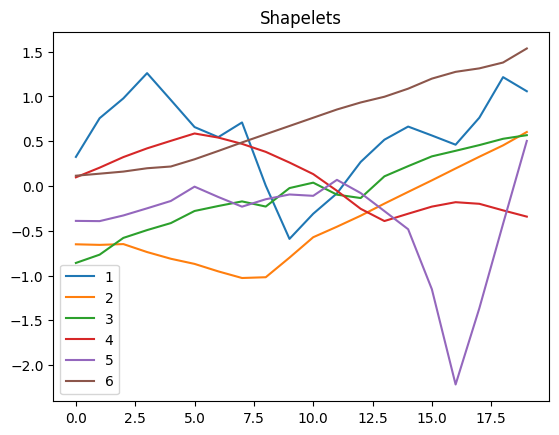

In [396]:
for i in range(len(shapelet_list)):
    plt.plot(shapelet_list[i],label =i+1)

plt.title("Shapelets")
plt.legend()
plt.show()

In [397]:
weights, biases = learning_shapelets.get_weights_linear_layer()